# WE PRESENT BELOW THE EMPIRICAL RESULTS OF OUR IMPLEMENTATION.
## TO REPRODUCE THE RESULTS YOU CAN RUN `main.py` IN EACH FOLDER CORRESPONDING TO EACH DATASET AND EXPERIMENT.
## THE CODE AND PROGRESS ARE ALSO FOUND AT OUR GITHUB: [controlVAE GIT](https://github.com/saashd/controlVAE)

# Imports

In [1]:
from Aux_functions import reconstruct_celebA,reconstruct_MNIST,display_celebA,display_MNIST
from Aux_functions import plot_figure,show_images_grid,select_img_samples,interpolate_gif
from Image_Generation.controlVAE import controlVAE as controlVAE_Img_Generation
from Disentangling.controlVAE import controlVAE as controlVAE_Disentangling

from dataLoader import load_celeba,load_dSprites,load_mnist
from ipywidgets import Output, GridspecLayout
from IPython import display
import random 
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  Experimental details for Image Generation:


To reproduce paper's main results we implemented control VAE and PI controller using settings that were described in the paper:<br> 

    batch size:  we used batch size = 100 as recommended at section 5.3-Effect of Batch Size of ELBO
    learning rate: we used learning rate of 1e-2, instead of 1e-3 used in the paper (appendix B.2) to accelerate the process.
    encoder and decoder architecture: as described in the paper (appendix B.2)
    epochs = 600

In PI Controller we set $\beta_{max}=1 \beta_{min}=0$ as mentioned in section 3.6 - Applications of ControlVAE

## celebA

Additional params set for celebA dataset:<br>

    latent dims = 500 as recommended in the paper (appendix B.2)
    num chanels = 3 as recommended in the paper (appendix B.2)
    train size = 2000




We trained VAE, betaVAE (beta=100) and controlVAE with different set points (170,180,200).<br>
After the training we saved the models and saved their outputs to pickle file.

First of all, we load the saved models and present reconstructed images to compare between models.<br>
Then, we load the pickle files to present and compare between loss and kl divergence of the models.

In [2]:
# Load saved models
VAE = controlVAE_Img_Generation(500, 3)
VAE.load_state_dict(torch.load('./Image_Generation/celebA/VAE_0_model', map_location=torch.device('cpu')))

controlVAE_170 = controlVAE_Img_Generation(500, 3)
controlVAE_170.load_state_dict(torch.load('./Image_Generation/celebA/controlVAE_170_model', map_location=torch.device('cpu')))

betaVAE_100 = controlVAE_Img_Generation(500, 3)
betaVAE_100.load_state_dict(torch.load('./Image_Generation/celebA/betaVAE_100_model', map_location=torch.device('cpu')))

controlVAE_180 = controlVAE_Img_Generation(500, 3)
controlVAE_180.load_state_dict(torch.load('./Image_Generation/celebA/controlVAE_180_model', map_location=torch.device('cpu')))

controlVAE_200 = controlVAE_Img_Generation(500, 3)
controlVAE_200.load_state_dict(torch.load('./Image_Generation/celebA/controlVAE_200_model', map_location=torch.device('cpu')))

# Load 30 images from dataset
train_data = load_celeba(30,root='./data/CelebA')
images = iter(train_data).next()

In [3]:
# Recontruct images using different models
VAE_recon = reconstruct_celebA(images, VAE)
controlVAE_170_recon = reconstruct_celebA(images, controlVAE_170)
betaVAE_100_recon = reconstruct_celebA(images, betaVAE_100)
controlVAE_180_recon = reconstruct_celebA(images, controlVAE_180)
controlVAE_200_recon = reconstruct_celebA(images, controlVAE_200)

# Display reconstucted images and original input side by side
title=["Original CelebA Input","VAE Output",'controlVAE-170 Output','controlVAE-180 Output','controlVAE-200 Output','betaVAE-100 Output']
imgs=[images,VAE_recon,controlVAE_170_recon,controlVAE_180_recon,controlVAE_200_recon,betaVAE_100_recon]  
grid = GridspecLayout(3, 2)

for i, img in enumerate(imgs):
    out = Output()
    with out:
        display_celebA(img, title[i])
    if i<=1:
        grid[0, i] = out
    elif i<=3:
        grid[1, i-2] = out
    elif i<=5:
        grid[2, i-4] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### Comparing models on a CelebA dataset:

We saved one of the reconstucted images and compared the results: (see explanation regarding the colors below)

![celebA comparison](celebA-comperison.png)

The first image we'll discuss, marked with red square. In the original input woman smiles with teeth.
betaVAE-100 and controlVAE-170 recognize the smile, but without the teeth. On the contrary, original VAE and controlVAE-180\200 were able to reconstructed simle with teeth. Also, controlVAE-180 reconstructed better hair line and eye area.

The second image marked with blue rectangle to highlight the mouth area of a smiling man. Only controlVAE-170/200 could recognize the smile.

The last one marked with green rectangle to highlight the eye area of a woman. Original VAE reconstructed this area in better a way, than control VAEs. From controlVAEs one with set point 200 succeed better than the others.

### Performance comparisons:

We compared the reconstruction loss and KL divergence of different models.<br>
As expected, the reconstruction loss of beta-VAE-100 is the highest. Because the model multiplies KL divergence by high hyperparameter (100) so the model optimizes this component more than the reconsruction loss.<br>
controlVAE-200 achieves better reconstruction loss after 600 epochs, but other controlVAE also pretty close.

As we can see from the KL divergence graph, each controlVAE stabilizes to its set-point.  

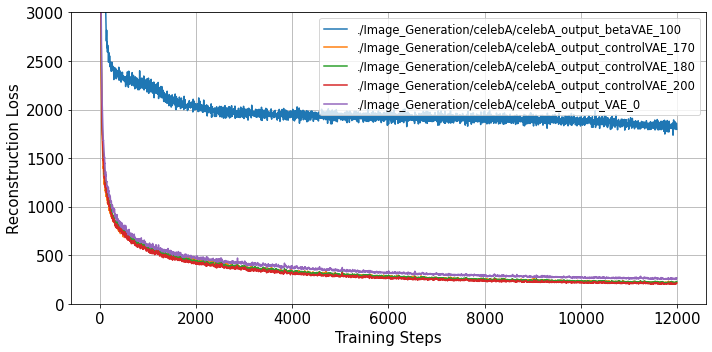

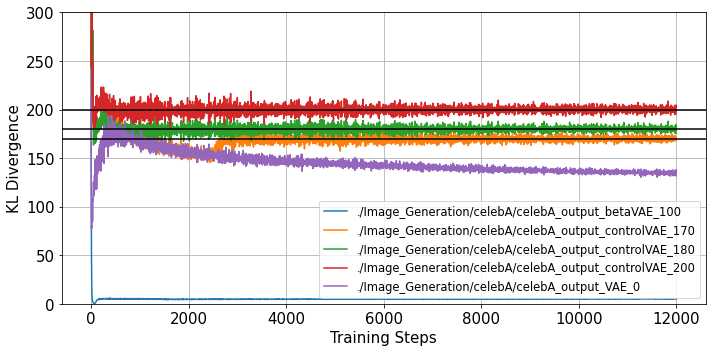

In [22]:
# load data from pickle and plot the output
files = [
    './Image_Generation/celebA/celebA_output_betaVAE_100',
    './Image_Generation/celebA/celebA_output_controlVAE_170',
    './Image_Generation/celebA/celebA_output_controlVAE_180',
    './Image_Generation/celebA/celebA_output_controlVAE_200',
    './Image_Generation/celebA/celebA_output_VAE_0'
]
plot_figure(files, 'recon_loss_list','celebA')
plot_figure(files, 'kl_list')

#### Conslusions on celebA:

The original paper did not provide image comparison or loss comarison on celebA dataset. <br>
Also, because of technical constrains we trained our model on small subset with only 600 epochs. <br>
Hence, we can not fully determine that controlVAE optimizes the reconstruction quality. <br>
In accordance to our results, in some cases controlVAE with different set points outperform original VAE and beta-VAE.


## MNIST

In adition to celebA we examined our models on MNIST dataset, as we were asked in project guidelines.<br>
Additional params set for MNIST dataset:<br>

        train size = 10000
        latent dims = 2
        num chanels = 1
        
We trained VAE, 100-VAE and control VAE with different set points (170,180,200). After the training we saved the models and saved their outputs to pickle file.

First of all, we load the saved models, present reconstructed images and  interpolation between digits, to compare between models.

Then, we load the pickle files to present and compare between loss and kl of the models.



In [8]:
# Load models
VAE = controlVAE_Img_Generation(2, 1)
VAE.load_state_dict(torch.load('./Image_Generation/MNIST/VAE_0_model', map_location=torch.device('cpu')))

controlVAE_170 = controlVAE_Img_Generation(2, 1)
controlVAE_170.load_state_dict(torch.load('./Image_Generation/MNIST/controlVAE_170_model', map_location=torch.device('cpu')))

controlVAE_180 = controlVAE_Img_Generation(2, 1)
controlVAE_180.load_state_dict(torch.load('./Image_Generation/MNIST/controlVAE_180_model', map_location=torch.device('cpu')))

controlVAE_200 = controlVAE_Img_Generation(2, 1)
controlVAE_200.load_state_dict(torch.load('./Image_Generation/MNIST/controlVAE_200_model', map_location=torch.device('cpu')))

betaVAE_100 = controlVAE_Img_Generation(2, 1)
betaVAE_100.load_state_dict(torch.load('./Image_Generation/MNIST/betaVAE_100_model', map_location=torch.device('cpu')))

# Load 30 images from dataset
train_data = load_mnist(30)
images, labels = iter(train_data).next()

In [9]:
# create interpolation between digits
x_1 = images[labels == 1][1].to(device)  # find a 1
x_2 = images[labels == 0][1].to(device)  # find a 0
interpolate_gif(VAE, "vae", x_1, x_2)
interpolate_gif(controlVAE_170, "controlVAE_170", x_1, x_2)
interpolate_gif(controlVAE_180, "controlVAE_180", x_1, x_2)
interpolate_gif(controlVAE_200, "controlVAE_200", x_1, x_2)
interpolate_gif(betaVAE_100, "betaVAE_100", x_1, x_2)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [10]:
# diplsay interpolations per model
filepaths=["vae.gif","controlVAE_170.gif","controlVAE_180.gif","controlVAE_200.gif","betaVAE_100.gif"]
grid = GridspecLayout(2, 3)

for i, filepath in enumerate(filepaths):
    out = Output()
    with out:
        print(filepath)
        display.display(display.IFrame(filepath, embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out
    else:
        grid[1, i-3] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Using the interpolation between digits we can find the ambiguous digits that lie between two centroids of our 10 digits.<br>
We can see that the interpolation of controlVAEs is much smoother and feels more natural as opposed to interpolation of betaVAE which is just one digit fading into each other. The transformations between digits more blurry, sometimes hard to understand what is the digit.<br>
The original VAE tends to change fast between digits, somtimes fading and  not focusing on each digit.

In [11]:
# recontruct images using different models
VAE_recon = reconstruct_MNIST(images, VAE)
controlVAE_170_recon = reconstruct_MNIST(images, controlVAE_170)
controlVAE_180_recon = reconstruct_MNIST(images, controlVAE_180)
controlVAE_200_recon = reconstruct_MNIST(images, controlVAE_200)
betaVAE_100_recon = reconstruct_MNIST(images, betaVAE_100)

# display reconstucted images and original input side by side
title=["Original MNIST Input","VAE Output",'controlVAE-170 Output','controlVAE-180 Output','controlVAE-200 Output','betaVAE-100 Output']
imgs=[images,VAE_recon,controlVAE_170_recon,controlVAE_180_recon,controlVAE_200_recon,betaVAE_100_recon]
grid = GridspecLayout(3, 2)

for i, img in enumerate(imgs):
    out = Output()
    with out:
        display_MNIST(img, title[i])
    if i<=1:
        grid[0, i] = out
    elif i<=3:
        grid[1, i-2] = out
    elif i<=5:
        grid[2, i-4] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

beta-VAE-100 have difficulties to reconsruct the original input.<br>
There are inputs in which all models struggle to reconstruct.<br>
We noticed that when controlVAE-180 mistakes, it tends to reconstruct '7', while controlVAE-170 tends to reconstruct '9'.<br>
"Simple digits" like '1','0' even '2' are easier to be recognized by controlVAE with different set-point, unlike "3','8','4','9' (3 is similar to 8, and 4 is similar to 9)

### Performance coparisons:

We compared the reconstruction loss and KL divergence of different models.<br>
The graphs tendention is simmilar to one presented on celebA dataset.

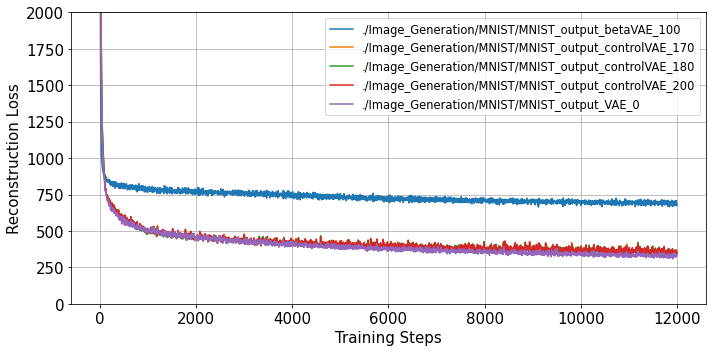

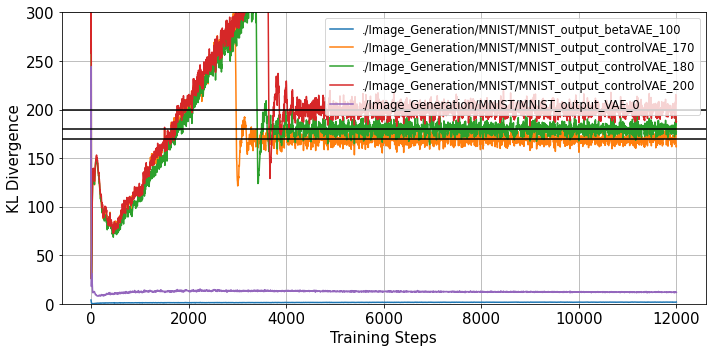

In [8]:
# load data from pickle and plot the output
files = [
        './Image_Generation/MNIST/MNIST_output_betaVAE_100',
        './Image_Generation/MNIST/MNIST_output_controlVAE_170',
        './Image_Generation/MNIST/MNIST_output_controlVAE_180',
        './Image_Generation/MNIST/MNIST_output_controlVAE_200',
        './Image_Generation/MNIST/MNIST_output_VAE_0'
    ]
plot_figure(files, 'recon_loss_list','MNIST')
plot_figure(files, 'kl_list')

#### Conslusions on MNIST:

MNIST dataset is simplier than celebaA to work with.<br>
The differences between the reconstructed digits are more significant then reconstructed faces from celebA dataset.<br>
We can conculude that controlVAE handles image generation better then other models discussed in the report.<br>

As we mentioned, the comparison results of reconstruction loss and KL divergence are the same on MNIST and on celebA.<br>
The output graphs on celebA and MNIST show consistent results with CIFAR-10 results presented in the paper.<br>
Thus, we conclude that our results match with the main results of the paper, as presented in the experimental section. 


# Experimental details for Disentanglement:

To reproduce paper's main results we implemented control VAE and PI controller using settings that were described in the paper (appendix B.1)):<br> 

    encoder and decoder architecture: as described in the paper
    batch size = 64 
    step= 0.15
    latent dims = 10 
    num chanels = 1
    
    
    training steps: we used K=1000 instead of K=5000 as used in the paper, to accelerate the process.
    In the paper KL divergence increases from 0.5 to desirable set-point by adding s=0.15 each 5000 iterations.
    Due to technical constraint, we had to descrease selected K value.
    learning rate: we used learning rate of 1e-2 instead of 1e-3 as used in the paper, to accelerate the process.
    epochs = 2000
    train size = 20000
    
In PI Controller we set  $\beta_{min}=1$ and we do not bound it from above, as mentioned in section 3.6 (Applications of ControlVAE)

### dSprites

Latent factors:

    Shape: square, ellipse, heart [0,2]
    Scale: 6 values linearly spaced in [0.5, 1]
    Orientation: 40 values in [0, 2*pi]
    Position X: 32 values in [0, 1]
    Position Y: 32 values in [0, 1]

We trained 100-VAE and control VAE with different set points (16,18). After the training we saved the models and saved their outputs to pickle file.

First of all, we load the saved models.<br>
We present image interpolation while fixing 4 out of 5 latent factors at a time, to compare between models.

Then, we load the pickle files to present and compare between loss, kl and beta hyperparameter of the models.

In [23]:
# Load models
controlVAE_16 = controlVAE_Disentangling(10, 1)
controlVAE_16.load_state_dict(torch.load('./Disentangling/controlVAE_16_model', map_location=torch.device('cpu')))

controlVAE_18 = controlVAE_Disentangling(10, 1)
controlVAE_18.load_state_dict(torch.load('./Disentangling/controlVAE_18_model', map_location=torch.device('cpu')))

betaVAE_100 = controlVAE_Disentangling(10, 1)
betaVAE_100.load_state_dict(torch.load('./Disentangling/betaVAE_100_model', map_location=torch.device('cpu')))


<All keys matched successfully>

In [24]:
# Load batch from dataset
torch.manual_seed(42)
train_data = load_dSprites(64,'./data/dSprites/dsprites_subset.npz')
images, labels = iter(train_data).next()

In [25]:
# diplsay interpolations per model
def display_interpolation(latent_factor_idx,latent_factor_value1,latent_factor_value2,latent_factor_class):
    titles=[f"controlVAE_16 dsprites {latent_factor_class}",f"controlVAE_18 dsprites {latent_factor_class}",f"betaVAE_100 dsprites {latent_factor_class}"]
    x_1 = images[labels[:, 0, latent_factor_idx] <= latent_factor_value1][1].to(device)
    x_2 = images[labels[:, 0, latent_factor_idx] >= latent_factor_value2][1].to(device)
    interpolate_gif(controlVAE_16, titles[0], x_1, x_2, 'dSprites')
    interpolate_gif(controlVAE_18, titles[1], x_1, x_2, 'dSprites')
    interpolate_gif(betaVAE_100, titles[2], x_1, x_2, 'dSprites')
    return titles

titles=display_interpolation(0,1,2,'Shape')
grid = GridspecLayout(1, 3)
for i, title in enumerate(titles):
    out = Output()
    with out:
        print(title)
        display.display(display.IFrame(title+'.gif', embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [26]:
titles=display_interpolation(1,0.5,1.,'Scale')
grid = GridspecLayout(1, 3)
for i, title in enumerate(titles):
    out = Output()
    with out:
        print(title)
        display.display(display.IFrame(title+'.gif', embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [27]:
titles=display_interpolation(2,0.5,6.,'Orientation')
grid = GridspecLayout(1, 3)
for i, title in enumerate(titles):
    out = Output()
    with out:
        print(title)
        display.display(display.IFrame(title+'.gif', embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [28]:
titles=display_interpolation(3,0.1,0.9,'X-position')
grid = GridspecLayout(1, 3)
for i, title in enumerate(titles):
    out = Output()
    with out:
        print(title)
        display.display(display.IFrame(title+'.gif', embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [29]:
titles=display_interpolation(4,0.1,0.9,'Y-position')
grid = GridspecLayout(1, 3)
for i, title in enumerate(titles):
    out = Output()
    with out:
        print(title)
        display.display(display.IFrame(title+'.gif', embed=True, width=300, height=300))
    if i<=2:
        grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

While presenting image interpolations, we fixed 4 out of 5 latent factors and visualized the changes -- having one "free" axis<br>
The results are:

* Shape: controlVAEs are able to make shape transformations. However, they also move in space (X-position). It means that the models have trouble to disentangle between the latent factor shape and positon.
BetaVAE-100 cant even change the shape, it mostly change the scale and position of the object.
* Scale: controlVAEs has troble to disentangle the scale factor. Shape of the object changed as well.
BetaVAE-100, on the other side, copes better with this task, the shape is stable during the scale transformations but, there is  position changes.
* Orientation: All the models fail this task. controlVAEs change shape and scale of the object, while betaVAE object is a circle, so it is hard to talk about object's orientation.
* X-position: controlVAEs can't disentangle the latent factors, the object "jumps" between locations in space.
BetaVAE-100 can't disentangle between x-position and scale, but not like controlVAEs, the movement of the object is smooth.
* Y-position: The results are simmilar to X-position. None of the models able to disentangle the latent factors.

### Performance comparisons:

We compared the reconstruction loss, KL divergence, beta hyperparameter of different models.<br>
As expected, the reconstruction loss of beta-VAE-100 is the highest. This is because the model multiplies KL divergence by high hyperparameter (100) so the model optimizes this component more than the reconsruction loss.<br>

As we can see from the reconstruction loss graph, our models converge faster, compared to the paper results. We suspect that this result is due to a change we made to the models parameters, like dataset set, learning rate, and training steps (K)

From the KL divergence graph,we can wee that each controlVAE stabilizes to its set-point starting from 0.5.  

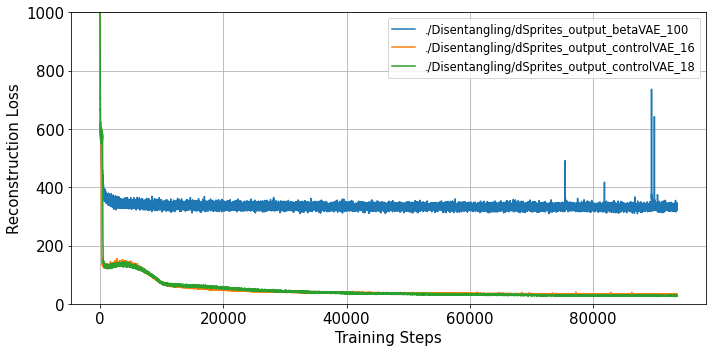

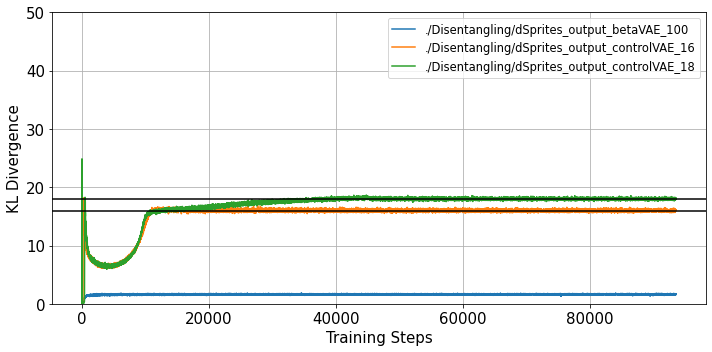

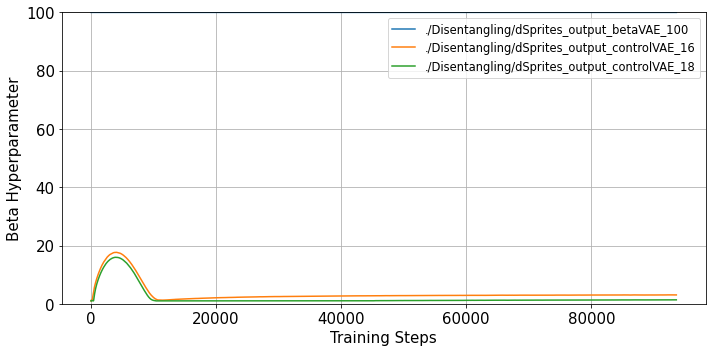

In [30]:
# load data from pickle and plot the output
files = [
        './Disentangling/dSprites_output_betaVAE_100',
        './Disentangling/dSprites_output_controlVAE_16',
        './Disentangling/dSprites_output_controlVAE_18',
    ]
plot_figure(files, 'recon_loss_list','dSprites')
plot_figure(files, 'kl_list','dSprites')
plot_figure(files, 'beta_list','dSprites')

#### Conslusions on dSprites:

In conclusion, we trained model on smaller dataset with less iterations. The results we got are less signicant then in the paper.
We can conclude that betaVAE entangling the shape and the scale, as mentioned in the paper.
However, we cant say that controlVAE succeed in disentangling all the latent factors, since our empirical results show otherwise.

The difference in the results can be due to the fact that we trained models that are a little bit different in terms of parameters (K, s, learning rate, number of iterations) and also on smaller dataset.



This dataset was cosntructed especially as a unit test of disentanglement properties of unsupervised models.
Unfortunately, We could not show results of disentanlment part of another dataset, as we could not find one that is simmilar to dSprites (has images and latend factor as labels).


## TO REPRODUCE THE RESULTS YOU CAN RUN `main.py` IN EACH FOLDER CORRESPONDING TO EACH DATASET AND EXPERIMENT.
## THE CODE AND PROGRESS ARE ALSO FOUND AT OUR GITHUB: [controlVAE GIT](https://github.com/saashd/controlVAE)